# Bag of Words to classify articles

## 1. Getting all the packages

In [3]:
# Getting all the imports
import numpy as np
import pandas as pd
import nltk

from sklearn.metrics import classification_report
import json
import itertools
from statistics import mean
import re
import string
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os


C:\Users\User\miniconda3\envs\PythonCPU\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


def load_file():
    with open('./data/arxiv-metadata-oai-snapshot.json') as f:
        for line in f:
            yield json.loads(line)


./data\arxiv-metadata-oai-snapshot.json


## 2. Exploratory Data Analysis

In [5]:
metadata = load_file()

subset = itertools.islice(metadata, 100000)

df = pd.DataFrame(subset)
df.head(5)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              100000 non-null  object
 1   submitter       100000 non-null  object
 2   authors         100000 non-null  object
 3   title           100000 non-null  object
 4   comments        87342 non-null   object
 5   journal-ref     50663 non-null   object
 6   doi             61265 non-null   object
 7   report-no       9464 non-null    object
 8   categories      100000 non-null  object
 9   license         56755 non-null   object
 10  abstract        100000 non-null  object
 11  versions        100000 non-null  object
 12  update_date     100000 non-null  object
 13  authors_parsed  100000 non-null  object
dtypes: object(14)
memory usage: 10.7+ MB


Let's check what's the value count of each unique element in the 'categories' column

In [7]:
val_count = df.categories.value_counts()
val_count.head(10)

astro-ph             16268
hep-ph                5326
quant-ph              4228
hep-th                3706
cond-mat.mtrl-sci     2083
gr-qc                 1953
cond-mat.mes-hall     1709
hep-ex                1517
cond-mat.str-el       1504
nucl-th               1351
Name: categories, dtype: int64

In [9]:
val_count.tail(10)

math.MG math.GR math.KT math.OA                    1
math.ST math.SP stat.TH                            1
nucl-th astro-ph gr-qc                             1
cond-mat.stat-mech nlin.AO physics.data-an         1
cs.DS cs.CC cs.CR                                  1
astro-ph cond-mat.dis-nn cond-mat.stat-mech        1
physics.chem-ph physics.atom-ph physics.comp-ph    1
cs.IT cs.NI math.IT math.ST stat.TH                1
astro-ph cond-mat.quant-gas                        1
physics.soc-ph cond-mat.other physics.data-an      1
Name: categories, dtype: int64

In [8]:
df.categories.nunique()

6066

That is a total of 6066 categories in this data! We will narrow it down to let's say 5 categories for now since it seems like there are a lot of subcategories

In [10]:
df_cat = df[df['categories'].isin(['hep-ph', 'quant-ph', 'astro-ph', 'hep-th', 'gr-qc'])] # high energy physics/quantum physics
df_cat['categories'].value_counts()

astro-ph    16268
hep-ph       5326
quant-ph     4228
hep-th       3706
gr-qc        1953
Name: categories, dtype: int64

In [12]:
df_cat = pd.get_dummies(df_cat, columns=['categories'])

In [14]:
X = df_cat['abstract']

# Dependent Variables
y = df_cat[['categories_astro-ph', 'categories_gr-qc',
       'categories_hep-ph', 'categories_hep-th', 'categories_quant-ph']]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


## 3. Creating bag of words

In [56]:
stop_words = _stop_words.ENGLISH_STOP_WORDS
# stop_words = nltk.corpus.stopwords.words()

# Function for basic cleaning/preprocessing texts
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of stopwords
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    return doc.lower()

vect = CountVectorizer(max_features=1000, preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

print(X_train_dtm.shape, X_test_dtm.shape)

(22036, 1000) (9445, 1000)


## 4.0 Data Modeling

To classify the articles, Naive Bayes and Logistic Regression are used to compare and contrast the difference in terms of classification performance.

In [62]:
def calculate_roc_auc(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [63]:
nb = MultiOutputClassifier(MultinomialNB()).fit(X_train_dtm, y_train)

lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=3000)) \
                    .fit(X_train_dtm, y_train)

In [59]:
# Creating an empty list of results
results = []
# Making predictions from all the trained models and measure performance for each
for model in [nb, lr]:
    # Extracting name of the model
    est = type(model.estimator).__name__
    # Actual output variables
    y_vals = y_test.to_numpy()
    # Model Probabilities for class 1 of each of the target variables
    y_preds = np.transpose(np.array(model.predict_proba(X_test_dtm))[:, :, 1])
    # Calculate Mean of the ROC-AUC
    mean_auc = mean(calculate_roc_auc(y_vals, y_preds))
    
    y_preds_2 = np.argmax(y_preds, axis=1)
    y_test_2 = np.argmax(y_vals, axis=1)
    print(f"The Classification report for {est}: \n")
    print(classification_report(y_preds_2, y_test_2))   
    # Append the name of the model and the mean_roc_auc into the results list
    results.append([est, mean_auc])


The Classification report for MultinomialNB: 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4689
           1       0.69      0.57      0.63       732
           2       0.89      0.91      0.90      1552
           3       0.82      0.77      0.79      1171
           4       0.91      0.89      0.90      1301

    accuracy                           0.90      9445
   macro avg       0.85      0.82      0.84      9445
weighted avg       0.89      0.90      0.90      9445

The Classification report for LogisticRegression: 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4730
           1       0.72      0.62      0.66       702
           2       0.89      0.90      0.89      1572
           3       0.80      0.79      0.79      1106
           4       0.92      0.88      0.90      1335

    accuracy                           0.90      9445
   macro avg       0.86      0.8

In [60]:
# Output the results as a table
pd.DataFrame(results, columns=["Model", "Mean AUC"])

,Model,Mean AUC
0,MultinomialNB,0.970303
1,LogisticRegression,0.980462


Let's check the important words for each class

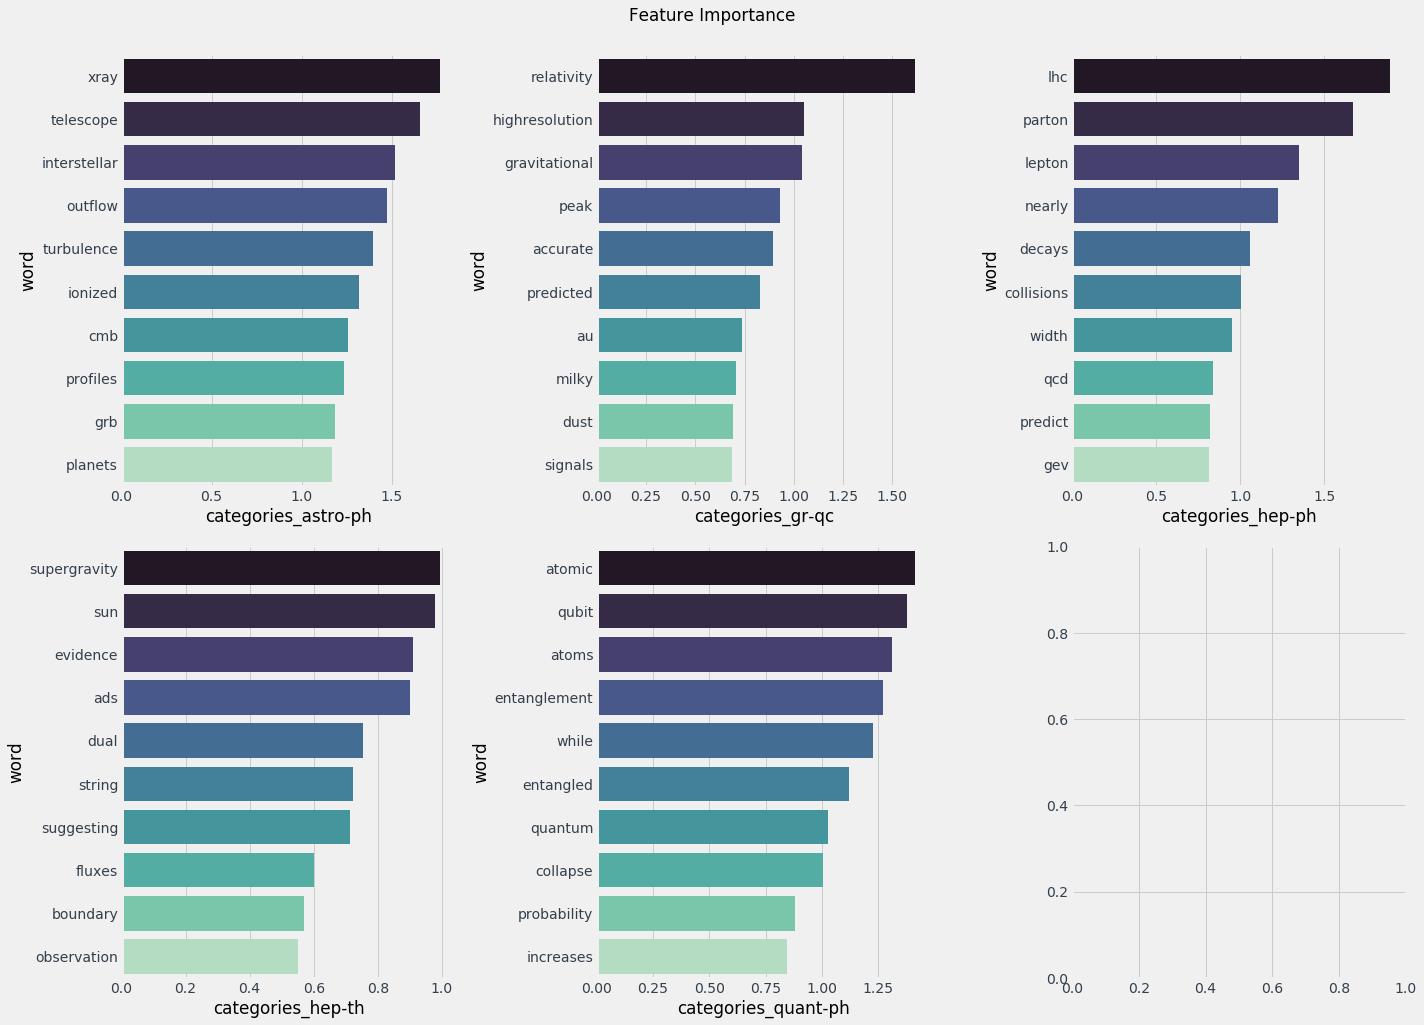

In [61]:
# Assigning the feature names to an empty list
feat_impts = [vect.get_feature_names()]

# For all the models save the feature importances in the list.estimators_ would give the internal models used by the multioutput regressor
for clf in lr.estimators_:
    feat_impts.append(clf.coef_.flatten())

y_cols = ['categories_astro-ph', 'categories_gr-qc', 'categories_hep-ph', 'categories_hep-th', 'categories_quant-ph']

# Saving the results in a dataframe
df_feats_impts = pd.DataFrame(np.transpose(np.array(feat_impts)), columns = ['word', 'categories_astro-ph', 'categories_gr-qc',
       'categories_hep-ph', 'categories_hep-th', 'categories_quant-ph'])
#Converting Feature Importance Columns from string to float
df_feats_impts[y_cols] = df_feats_impts[y_cols].astype("float32")
df_feats_impts.head()

#Creating Individual Feature Importance table by sorting on specific toxic-type column and selecting top 5 words
astro_fi = df_feats_impts[["word","categories_astro-ph"]].sort_values(by = "categories_astro-ph", ascending = False).head(10)
gr_fi = df_feats_impts[["word","categories_gr-qc"]].sort_values(by = "categories_gr-qc", ascending = False).head(10)
hep_ph_fi = df_feats_impts[["word","categories_hep-ph"]].sort_values(by = "categories_hep-ph", ascending = False).head(10)
hep_th_fi = df_feats_impts[["word","categories_hep-th"]].sort_values(by = "categories_hep-th", ascending = False).head(10)
quant_fi = df_feats_impts[["word","categories_quant-ph"]].sort_values(by = "categories_quant-ph", ascending = False).head(10)

plt.style.use('fivethirtyeight') 

#Plotting top 5 words based on coefficient values from the LR model
fig,(ax1, ax2) = plt.subplots(2,3,figsize=(20,15))
sns.barplot(x = "categories_astro-ph", y = "word", ax = ax1[0], data = astro_fi,  palette = 'mako')
sns.barplot(x = "categories_gr-qc", y = "word", ax = ax1[1], data = gr_fi, palette = 'mako')
sns.barplot(x = "categories_hep-ph", y = "word", ax = ax1[2], data = hep_ph_fi, palette = 'mako')
sns.barplot(x = "categories_hep-th", y = "word", ax = ax2[0], data = hep_th_fi, palette = 'mako')
sns.barplot(x = "categories_quant-ph", y = "word", ax = ax2[1], data = quant_fi, palette = 'mako')
plt.suptitle("Feature Importance")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
